In [41]:
import pandas as pd
import numpy as np

#I just copied the columns for death prediction by other models and pasted them into the csv file

df = pd.read_csv('notes_with_survival_probability.csv')
df_los = pd.read_csv('notes_with_los_probability.csv')

In [42]:
#convert to los_icu_class to binary
df_los.loc[df_los['los_icu_class'] == 'less than 3 days', 'los_icu_class'] = 0
df_los.loc[df_los['los_icu_class'] == 'greater than or equal to 3 days', 'los_icu_class'] = 1
df_los['los_icu_class'] = pd.to_numeric(df_los['los_icu_class'])

df.head()

,id,los_icu_class,text,los_icu,icu_death,text_embeddings,Survive,Death_Text,Death_Static_RF,Death_Static_XGB,Death_Static_LSTM,Death_Static_TCN
0,20001305,less than 3 days,INDICATION: ___ with copd in resp distress in...,2.78,1,[ 4.95544821e-02 -3.71760167e-02 -1.27426326e-...,0.332797,0.667203,0.530172,0.936458,0.259296,0.675421
1,20001361,greater than or equal to 3 days,CHEST X-RAY DATED ___.\n\nCOMPARISON: None.\n...,6.05,0,[ 7.76797682e-02 -3.10484290e-01 -2.07543001e-...,0.322157,0.677843,0.522452,0.908735,0.013331,0.000466
2,20001770,less than 3 days,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...,2.87,0,[ 1.32888228e-01 -1.91068441e-01 -2.99163219e-...,0.671787,0.328213,0.537038,0.912528,0.115600,0.021466
3,20002506,greater than or equal to 3 days,EXAMINATION: CTA HEAD AND CTA NECK Q16 CT NEC...,6.56,0,[ 4.52079531e-03 -2.32567102e-01 2.54237894e-...,0.714918,0.285082,0.612666,0.995528,0.027471,0.059141
4,20003491,less than 3 days,EXAMINATION: Chest radiograph\n\nINDICATION: ...,2.54,0,[ 7.84905553e-02 -1.51299506e-01 2.41509974e-...,0.884381,0.115619,0.575646,0.970156,0.013197,0.001228


# Functions from Shih Jen

In [3]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

def plot_roc_curve(models, Xtest, ytest):
    plt.figure(figsize=(10,8))
    for model_name, model in models.items():
        if hasattr(model, 'predict_proba'):
            ypred_proba = model.predict_proba(Xtest)[:, 1]
        elif hasattr(model, 'decision_function'):
            ypred_proba = model.decision_function(Xtest)
#         # for neural network
#         else:
#             model.eval()
#             Xtest_tensor = torch.FloatTensor(Xtest)
#             with torch.no_grad():
#                 outputs = model(Xtest_tensor)
#                 ypred_proba = torch.sigmoid(outputs).cpu().numpy()  # convert output to probabilities using sigmoid function

        fpr, tpr, thresholds = roc_curve(ytest, ypred_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0,1],[0,1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.4)
    plt.show()
    
def eval_metrics(models, Xtest, ytest):
    res_df = []
    for model_name, model in models.items():
        if hasattr(model, 'predict_proba'):
            ypred_proba = model.predict_proba(Xtest)[:, 1]
            ypred = model.predict(Xtest)
        elif hasattr(model, 'decision_function'):
            ypred_proba = model.decision_function(Xtest)
            ypred = model.predict(Xtest)
#         # for neural network
#         else:
#             model.eval()
#             with torch.no_grad():
#                 Xtest_tensor = torch.FloatTensor(Xtest)
#                 outputs = model(Xtest_tensor)
#                 ypred_proba = torch.sigmoid(outputs).cpu().numpy()  # convert output to probabilities using sigmoid function
#                 ypred = (ypred_proba >= 0.5).astype(int)

        fpr, tpr, thresholds = roc_curve(ytest, ypred_proba)
        roc_auc = auc(fpr, tpr)
        precision = precision_score(ytest, ypred, average='macro', zero_division=0)
        recall = recall_score(ytest, ypred, average='macro', zero_division=0)
        f1 = f1_score(ytest, ypred, average='macro', zero_division=0)

        result = pd.DataFrame({'AUROC':roc_auc,
                               'Precision':precision,
                               'Recall':recall,
                               'F1 Score':f1}, index=[model_name])
        res_df.append(result)
    
    final_df = pd.concat(res_df)
    return final_df

/Users/wenruiwah/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Test various classifiers and stacking for death classification

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


X_death = df[["Death_Text",
        "Death_Static_LSTM",
#        "Death_Static_XGB",
#        "Death_Static_RF",
#         "Death_Static_TCN"
       ]]
y_death = df['icu_death']


# X = df_los[["long_stay_text",
# #             "long_stay_LSTM",
# #             "long_stay_XGB",
# #             "long_stay_RF",
#             "long_stay_TCN"
#            ]]

# y = df_los['los_icu_class']

X_death_train, X_death_test, y_death_train, y_death_test = train_test_split(X_death, y_death, test_size=0.2, stratify=y_death, shuffle=True, random_state=42)

logR_death = LogisticRegression(random_state=42)
logR_death.fit(X_death_train, y_death_train)

GNB_death = GaussianNB()
GNB_death.fit(X_death_train, y_death_train)

RF_death = RandomForestClassifier(random_state=42)
RF_death.fit(X_death_train, y_death_train)

DecisionTree_death = DecisionTreeClassifier(random_state=42)
DecisionTree_death.fit(X_death_train, y_death_train)

estimators = []
estimators.append(('Logistic Regression Classifier', LogisticRegression(random_state=42) ))
estimators.append(('Gaussian Naive Bayes Classifier', GaussianNB() ))
estimators.append(('Random Forest Classifier', RandomForestClassifier(random_state=42) ))
estimators.append(('Decision Tree Classifier', DecisionTreeClassifier(random_state=42) ))

logisticR = LogisticRegression(random_state=42)

SC_death = StackingClassifier(estimators=estimators,
                        final_estimator=logisticR,
                        cv=6,
                        #stack_method='predict_proba'
                       )
SC_death.fit(X_death_train, y_death_train)


StackingClassifier(cv=6,
                   estimators=[('Logistic Regression Classifier',
                                LogisticRegression(random_state=42)),
                               ('Gaussian Naive Bayes Classifier',
                                GaussianNB()),
                               ('Random Forest Classifier',
                                RandomForestClassifier(random_state=42)),
                               ('Decision Tree Classifier',
                                DecisionTreeClassifier(random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

# Results for death training

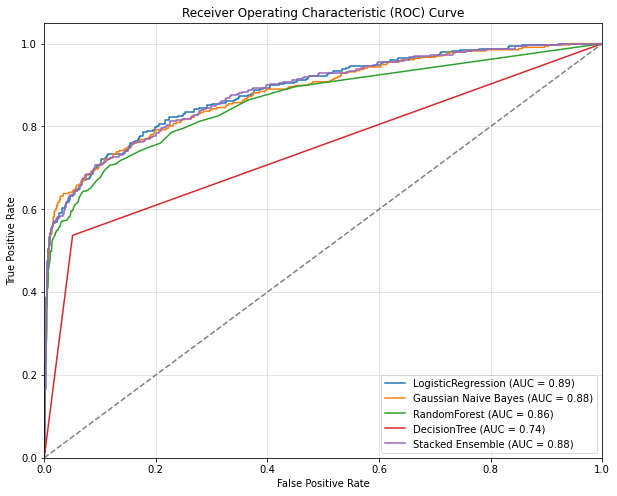

,AUROC,Precision,Recall,F1 Score
LogisticRegression,0.885111,0.907688,0.758001,0.811560
Gaussian Naive Bayes,0.879488,0.862421,0.787974,0.819600
RandomForest,0.860288,0.853547,0.760125,0.797534
DecisionTree,0.743102,0.747667,0.743102,0.745354
Stacked Ensemble,0.883369,0.902379,0.760456,0.812130


In [44]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

models_death = {'LogisticRegression':logR_death,
          'Gaussian Naive Bayes':GNB_death,
          'RandomForest':RF_death,
         'DecisionTree':DecisionTree_death,
         'Stacked Ensemble':SC_death}

# check model performance
plot_roc_curve(models_death, X_death_test, y_death_test)
eval_metrics(models_death, X_death_test, y_death_test)

## Export best death classifier for ensemble

In [45]:
# Import Pickle
import pickle

with open('logreg_ensemble_death.pkl', 'wb') as file:
    pickle.dump(logR_death, file)

# Test various classifiers and stacking for LOS classification

In [94]:
X_los = df_los[["long_stay_text",
            "long_stay_LSTM",
#             "long_stay_XGB",
#             "long_stay_RF",
            "long_stay_TCN"
           ]]

y_los = df_los['los_icu_class']

X_los_train, X_los_test, y_los_train, y_los_test = train_test_split(X_los, y_los, test_size=0.2, stratify=y_los, shuffle=True, random_state=42)

logR_los = LogisticRegression(random_state=42)
logR_los.fit(X_los_train, y_los_train)

GNB_los = GaussianNB()
GNB_los.fit(X_los_train, y_los_train)

RF_los = RandomForestClassifier(random_state=42)
RF_los.fit(X_los_train, y_los_train)

DecisionTree_los = DecisionTreeClassifier(random_state=42)
DecisionTree_los.fit(X_los_train, y_los_train)

estimators = []
estimators.append(('Logistic Regression Classifier', LogisticRegression(random_state=42) ))
estimators.append(('Gaussian Naive Bayes Classifier', GaussianNB() ))
estimators.append(('Random Forest Classifier', RandomForestClassifier(random_state=42) ))
estimators.append(('Decision Tree Classifier', DecisionTreeClassifier(random_state=42) ))

logisticR = LogisticRegression(random_state=42)

SC_los = StackingClassifier(estimators=estimators,
                        final_estimator=logisticR,
                        cv=6,
                        #stack_method='predict_proba'
                       )
SC_los.fit(X_los_train, y_los_train)

StackingClassifier(cv=6,
                   estimators=[('Logistic Regression Classifier',
                                LogisticRegression(random_state=42)),
                               ('Gaussian Naive Bayes Classifier',
                                GaussianNB()),
                               ('Random Forest Classifier',
                                RandomForestClassifier(random_state=42)),
                               ('Decision Tree Classifier',
                                DecisionTreeClassifier(random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

# Results for los training

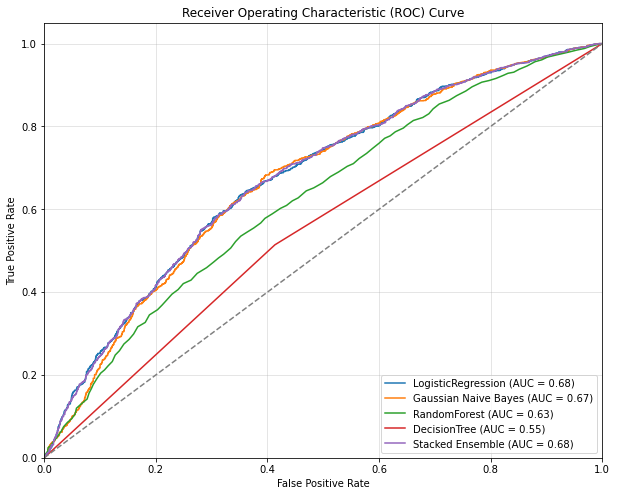

,AUROC,Precision,Recall,F1 Score
LogisticRegression,0.676191,0.635019,0.634791,0.634879
Gaussian Naive Bayes,0.671033,0.638154,0.638521,0.638194
RandomForest,0.626511,0.589933,0.589663,0.589730
DecisionTree,0.550395,0.550527,0.550395,0.550411
Stacked Ensemble,0.676190,0.636855,0.636599,0.636695


In [89]:
models_los = {'LogisticRegression':logR_los,
          'Gaussian Naive Bayes':GNB_los,
          'RandomForest':RF_los,
         'DecisionTree':DecisionTree_los,
         'Stacked Ensemble':SC_los}

# check model performance
plot_roc_curve(models_los, X_los_test, y_los_test)
eval_metrics(models_los, X_los_test, y_los_test)

## Export best los model

In [283]:
with open('GNB_ensemble_los.pkl', 'wb') as file:
    pickle.dump(GNB_los, file)

# Output data for death, using logR_death

In [38]:
#load death probs from LSTM and text, I already combined manually 
validation_death_df = pd.read_csv("lstm_probs_of_death.csv")
validation_death_df.dtypes
validation_death_df

,lstm_probs_of_death,text_probs_of_death,Death
0,0.017012,0.295472,0
1,0.012787,0.219437,0
2,0.621807,0.709828,1
3,0.015258,0.429824,0
4,0.020475,0.456270,0
...,...,...,...
4076,0.078630,0.433242,0
4077,0.504459,0.784476,1
4078,0.036726,0.649372,0
4079,0.011150,0.077565,0


In [78]:
#get probs
death_predictors = validation_death_df[['lstm_probs_of_death','text_probs_of_death']].copy()
probability = logR_death.predict_proba(death_predictors)
probability_df = pd.DataFrame(probability, columns=['Survive_prob', 'Death_prob'])
#get binary
binary = logR_death.predict(death_predictors)
probability_df['death'] = binary
probability_df.head()
#probability_df.to_csv('Validation_death_combined_3.csv')


/Users/wenruiwah/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- lstm_probs_of_death
- text_probs_of_death
Feature names seen at fit time, yet now missing:
- Death_Static_LSTM
- Death_Text

  warnings.warn(message, FutureWarning)
/Users/wenruiwah/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- lstm_probs_of_death
- text_probs_of_death
Feature names seen at fit time, yet now missing:
- Death_Static_LSTM
- Death_Text

  warnings.warn(message, FutureWarning)


,Survive_prob,Death_prob,death
0,9.946602e-01,0.005340,0
1,9.993124e-01,0.000688,0
2,9.366563e-11,1.000000,1
3,5.338344e-01,0.466166,0
4,2.340640e-01,0.765936,0


# Assess performance of death against validation

In [60]:
from sklearn.metrics import roc_auc_score
death_predictors = validation_death_df[['lstm_probs_of_death','text_probs_of_death']].copy()
death_validation = logR_death.predict(death_predictors)

y = validation_death_df['Death']
ypred = death_validation

print('AUROC:', roc_auc_score(y, ypred))
print('Precision', precision_score(y, ypred, average='macro', zero_division=0))
print('Recall', recall_score(y, ypred, average='macro', zero_division=0))
print('F1 score:', f1_score(y, ypred, average='macro', zero_division=0))

AUROC: 0.9520302833301286
Precision 0.9775366851637493
Recall 0.9520302833301286
F1 score: 0.9642792055612335


/Users/wenruiwah/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- lstm_probs_of_death
- text_probs_of_death
Feature names seen at fit time, yet now missing:
- Death_Static_LSTM
- Death_Text

  warnings.warn(message, FutureWarning)


# Output los performance, using GNB_los

In [61]:
#read files from text and TCN and LSTM
validation_los = pd.read_csv('text_los_probability_validation.csv')
validation_los

,id,los_icu_class,text,los_icu,icu_death,text_embeddings,death,less than 3 days,greater than or equal to 3 days,greater than or equal to 3 days_TCN,greater than or equal to 3 days_LSTM
0,20003425,greater than or equal to 3 days,ADDENDUM Findings were communicated to the EN...,4.00,0,[ 1.22243397e-01 -2.15054199e-01 -6.55379891e-...,0,0.509363,0.490637,0.586819,0.971367
1,20008724,less than 3 days,INDICATION: History: ___ with r apical ptx /...,1.37,0,[ 7.67850280e-02 -2.23866910e-01 9.81518067e-...,0,0.538280,0.461720,0.603712,0.974720
2,20009330,greater than or equal to 3 days,EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...,5.76,0,[ 1.15483336e-01 -1.93019524e-01 -4.55525294e-...,1,0.394143,0.605857,0.117265,0.993173
3,20014219,greater than or equal to 3 days,EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...,19.13,0,[ 2.61465795e-02 -8.01570565e-02 8.03710613e-...,0,0.647051,0.352949,0.453035,0.968533
4,20015722,less than 3 days,EXAMINATION: CT HEAD W/O CONTRAST Q111 CT HEA...,2.60,0,[ 2.12557286e-01 -2.19507277e-01 -3.41315009e-...,0,0.492372,0.507628,0.359827,0.981819
...,...,...,...,...,...,...,...,...,...,...,...
4076,29985535,less than 3 days,INDICATION: Presented from outside hospital w...,2.12,0,[ 5.98312467e-02 -8.12149495e-02 -1.31993696e-...,0,0.503882,0.496118,0.553988,0.967959
4077,29987115,greater than or equal to 3 days,"AP CHEST 9:38 P.M. ON ___\n\nHISTORY: Lupus, ...",4.14,1,[ 1.37579292e-01 -1.87411323e-01 -2.02495661e-...,1,0.205841,0.794159,0.917006,0.013084
4078,29988601,greater than or equal to 3 days,"INDICATION: ___ man with fall, please rule ou...",10.64,0,[ 1.49990827e-01 -1.99247926e-01 -3.02581862e-...,0,0.320071,0.679929,0.228980,0.976168
4079,29988615,less than 3 days,INDICATION: ___ female with suspected pneumon...,2.72,0,[-5.06151691e-02 -1.96244091e-01 -2.83730775e-...,0,0.721566,0.278434,0.000120,0.046908


In [62]:
#convert los to binary
validation_los.loc[validation_los['los_icu_class'] == 'less than 3 days', 'los_icu_class'] = 0
validation_los.loc[validation_los['los_icu_class'] == 'greater than or equal to 3 days', 'los_icu_class'] = 1
validation_los['los_icu_class'] = pd.to_numeric(validation_los['los_icu_class'])

validation_los.dtypes

id                                        int64
los_icu_class                             int64
text                                     object
los_icu                                 float64
icu_death                                 int64
text_embeddings                          object
death                                     int64
less than 3 days                        float64
greater than or equal to 3 days         float64
greater than or equal to 3 days_TCN     float64
greater than or equal to 3 days_LSTM    float64
dtype: object

In [102]:
los_predictors = validation_los[['greater than or equal to 3 days',
                                 "greater than or equal to 3 days_LSTM",
                                 'greater than or equal to 3 days_TCN'
                                ]].copy()
los_predictors
los_validation = logR_los.predict(los_predictors)
validation_los['los_predicted'] = los_validation
validation_los.head()

/Users/wenruiwah/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- greater than or equal to 3 days
- greater than or equal to 3 days_LSTM
- greater than or equal to 3 days_TCN
Feature names seen at fit time, yet now missing:
- long_stay_LSTM
- long_stay_TCN
- long_stay_text

  warnings.warn(message, FutureWarning)


,id,los_icu_class,text,los_icu,icu_death,text_embeddings,death,less than 3 days,greater than or equal to 3 days,greater than or equal to 3 days_TCN,greater than or equal to 3 days_LSTM,los_predicted
0,20003425,1,ADDENDUM Findings were communicated to the EN...,4.00,0,[ 1.22243397e-01 -2.15054199e-01 -6.55379891e-...,0,0.509363,0.490637,0.586819,0.971367,1
1,20008724,0,INDICATION: History: ___ with r apical ptx /...,1.37,0,[ 7.67850280e-02 -2.23866910e-01 9.81518067e-...,0,0.538280,0.461720,0.603712,0.974720,0
2,20009330,1,EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...,5.76,0,[ 1.15483336e-01 -1.93019524e-01 -4.55525294e-...,1,0.394143,0.605857,0.117265,0.993173,0
3,20014219,1,EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...,19.13,0,[ 2.61465795e-02 -8.01570565e-02 8.03710613e-...,0,0.647051,0.352949,0.453035,0.968533,0
4,20015722,0,EXAMINATION: CT HEAD W/O CONTRAST Q111 CT HEA...,2.60,0,[ 2.12557286e-01 -2.19507277e-01 -3.41315009e-...,0,0.492372,0.507628,0.359827,0.981819,0


In [103]:
from sklearn.metrics import roc_auc_score

y = validation_los['los_icu_class']
ypred = validation_los['los_predicted']

print('AUROC:', roc_auc_score(y, ypred))
print('Precision', precision_score(y, ypred, average='macro', zero_division=0))
print('Recall', recall_score(y, ypred, average='macro', zero_division=0))
print('F1 score:', f1_score(y, ypred, average='macro', zero_division=0))

AUROC: 0.5383362045180784
Precision 0.5401216836807843
Recall 0.5383362045180784
F1 score: 0.5344412796280262
